In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm.auto import tqdm
import torch 
from torch import nn
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
df = pd.read_csv('data/chineseMNIST.csv')

In [4]:
df.sample(10)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
1711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,十
8771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,二
8846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,二
11494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,五
8188,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,二
9289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,三
2508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100,百
7725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,一
12997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,六
5667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100000000,亿


In [5]:
df.shape

(15000, 4098)

In [6]:
feature_vectors, labels = df.iloc[:, :-2], df.iloc[:, -2:]

In [7]:
feature_vectors.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4086,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
labels.value_counts()

label      character
0          零            1000
1          一            1000
2          二            1000
3          三            1000
4          四            1000
5          五            1000
6          六            1000
7          七            1000
8          八            1000
9          九            1000
10         十            1000
100        百            1000
1000       千            1000
10000      万            1000
100000000  亿            1000
Name: count, dtype: int64

In [9]:
one_hot = OneHotEncoder(sparse_output = False)

In [10]:
encoded_labels = one_hot.fit_transform(labels.iloc[:, :1].values)

In [11]:
np_features, np_targets = feature_vectors.values.astype(np.float32), encoded_labels.copy()

In [12]:
np_labels = labels.iloc[:, :1].values

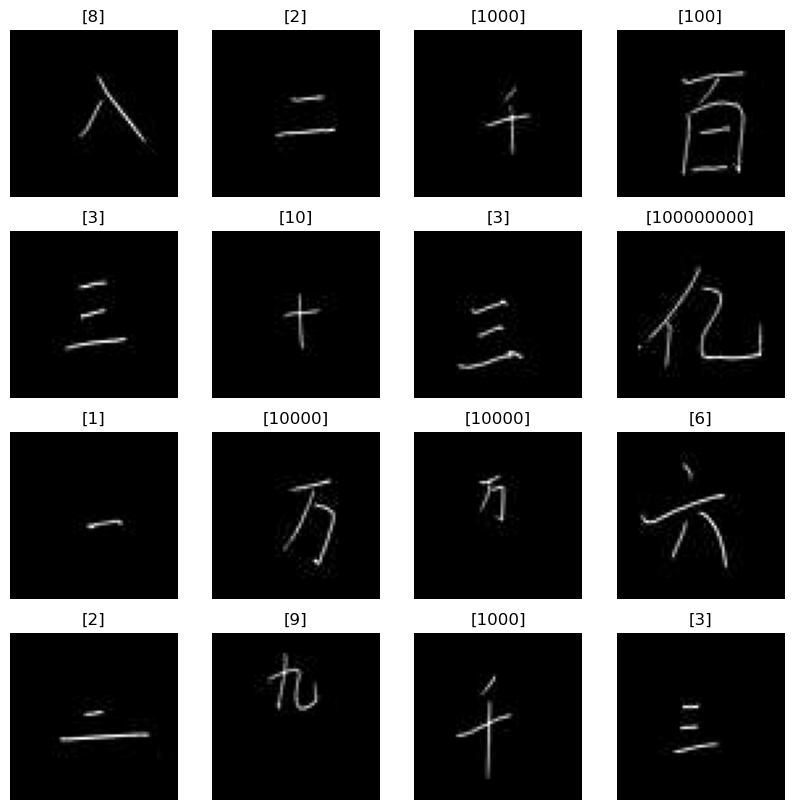

In [13]:
fig = plt.figure(figsize = (10, 10))

rows, cols = 4,4

for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    choice = random.randint(0, 14999)
    chosen_image = np_features[choice, :]
    chosen_label = np_labels[choice]
    plt.imshow(chosen_image.reshape(64, 64, 1), cmap = 'gray')
    plt.title(chosen_label)
    plt.axis(False)

In [14]:
class_names = np.unique(np_labels)
class_names

array([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,       100,
            1000,     10000, 100000000])

In [15]:
np_targets

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
np_target_features = np.array([i.reshape(1, 64, 64) for i in np_features])

In [17]:
torch_features = torch.tensor(np_target_features, dtype = torch.float)
torch_target = torch.tensor(np_targets)

In [18]:
torch_features.shape, torch_features.dtype, torch_target.shape

(torch.Size([15000, 1, 64, 64]), torch.float32, torch.Size([15000, 15]))

In [19]:
ds = TensorDataset(torch_features, torch_target)

In [20]:
train_ds, test_ds, val_ds = random_split(ds, [0.8, 0.1, 0.1])

In [21]:
len(train_ds), len(test_ds), len(val_ds)

(12000, 1500, 1500)

In [22]:
train_dl = DataLoader(dataset = train_ds, batch_size = 64, shuffle = True)
val_dl = DataLoader(dataset = val_ds, shuffle = False)
test_dl = DataLoader(dataset = test_ds, shuffle = False)

In [23]:
train_image_batch, train_image_label = next(iter(train_dl))

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [149]:
class ChineseMnistModelV0(nn.Module):
    def __init__(self, class_names):
        super(ChineseMnistModelV0, self).__init__()

        self.class_names = class_names
        
        self.input_layer = nn.Sequential(
            # input conv
            nn.Conv2d(1,128,2, 3),
            nn.ReLU(),
            # second conv
            nn.Conv2d(128,10,2, 2),
            nn.ReLU(),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*10*10, 100),
            nn.ReLU(),
            nn.Linear(100, out_features = self.class_names),
        )
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X /= 255
        X = self.input_layer(X)
        X = self.output(X)
        return X

In [150]:
model_0 = ChineseMnistModelV0(len(class_names)).to(device)

In [151]:
pred = model_0(train_image_batch[0].to(dtype = torch.float).unsqueeze(dim = 0))

In [152]:
train_image_batch[0].shape

torch.Size([1, 64, 64])

In [153]:
pred.shape

torch.Size([1, 15])

In [177]:
pred

tensor([[ 0.1339, -0.0910,  0.0675, -0.0132,  0.0625, -0.0315,  0.0522,  0.0822,
          0.0319,  0.0943, -0.0424, -0.0837, -0.0494, -0.0350,  0.0771],
        [ 0.1339, -0.0910,  0.0675, -0.0132,  0.0625, -0.0315,  0.0522,  0.0822,
          0.0319,  0.0943, -0.0424, -0.0837, -0.0494, -0.0350,  0.0771],
        [ 0.1339, -0.0910,  0.0675, -0.0132,  0.0625, -0.0315,  0.0522,  0.0822,
          0.0319,  0.0943, -0.0424, -0.0837, -0.0494, -0.0350,  0.0771],
        [ 0.1339, -0.0910,  0.0675, -0.0132,  0.0625, -0.0315,  0.0522,  0.0822,
          0.0319,  0.0943, -0.0424, -0.0837, -0.0494, -0.0350,  0.0771],
        [ 0.1339, -0.0910,  0.0675, -0.0132,  0.0625, -0.0315,  0.0522,  0.0822,
          0.0319,  0.0943, -0.0424, -0.0837, -0.0494, -0.0350,  0.0771],
        [ 0.1402, -0.0926,  0.0511, -0.0124,  0.0662, -0.0386,  0.0566,  0.0824,
          0.0289,  0.1004, -0.0165, -0.0861, -0.0651, -0.0152,  0.0897],
        [ 0.1339, -0.0910,  0.0675, -0.0132,  0.0625, -0.0315,  0.0522,  0.0

In [168]:
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 1e-2, momentum = 0.9, weight_decay = 1e-3, nesterov = True)
loss_fn = nn.CrossEntropyLoss()

In [171]:
def fit(epochs, model, train_dl, test_dl, optimizer, loss_fn, device = 'cpu', step = 1):
    
    train_loss_count = list()
    test_loss_count = list()
    epoch_count = list()

    for epoch in tqdm(range(epochs)):

        train_loss = .0
        for X, y in train_dl:
            model.train()

            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_dl)
        train_loss_count.append(train_loss.detach().item())

        test_loss = .0
        with torch.inference_mode():
            for test_X, test_y in test_dl:
                test_X, test_y = test_X.to(device), test_y.to(device)
                test_pred = model(test_X)

                test_loss += loss_fn(test_pred, test_y)

            test_loss /= len(test_dl)
            test_loss_count.append(test_loss.detach().item())

        epoch_count.append(epoch)
        if epoch % step == 0:
            print(f'Epoch: {epoch}')
            print(f'Train Loss -> {train_loss:.3f} | Test Loss -> {test_loss:.3f}')
            print('----------------------------------------------------------------------------')
            print('----------------------------------------------------------------------------')

        return {
        'epochs': epoch_count,
        'train_loss': train_loss_count,
        'test_loss': test_loss_count,
        }
        

In [ ]:
def fit(epochs = 100, model_0, train_dl, test_dl, optimizer, loss_fn)

In [ ]:
loss_fn(

In [167]:
for x, y in test_dl:
    print(x)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       